In [1]:
import os
os.environ["PROJ_LIB"] = r'C:\Users\Mic Mic\anaconda3\pkgs\basemap-1.3.0-py38ha7665c8_0\Library\share\basemap' #fixr

from mpl_toolkits.basemap import Basemap, maskoceans
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import netCDF4 as nc
import scipy.io as sp
import numpy.random as rnd

## Plot mean RH for strong Habagat days

In [2]:
ph_rh = pd.read_csv('../ph_rh_habagat.csv',header=None).values

In [3]:
# norm_rh = ph_rh/ph_rh.max(axis=0)[None,:]
sum_rh = np.mean(ph_rh,axis=1)

norm_sum_rh = np.reshape(sum_rh,(15,13)) #np.reshape(sum_rh/sum_rh.max(),(15,13))

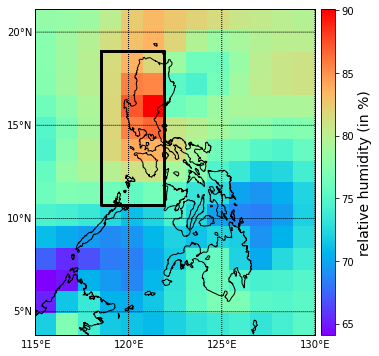

In [4]:
rh_lat = np.arange(3.75,21.5,1.25)
rh_lon = np.arange(115,131,1.25)

plt.figure(figsize=(8,6))

#draw basemap
m = Basemap(projection='cyl',llcrnrlon=115,urcrnrlon=130,llcrnrlat=3.75,urcrnrlat=21.25,resolution='i')
m.drawcoastlines(linewidth=1)
m.drawmapboundary(fill_color='aliceblue')

rh_imshow = m.imshow(np.flip(norm_sum_rh,axis=0),cmap='rainbow',zorder=1)

#draw latitudes and longitudes
parallels = np.arange(5,21,5)
m.drawparallels(parallels,labels=[True,False,True,False])
meridians = np.arange(115,141,5)
m.drawmeridians(meridians,labels=[True,False,False,True])

m.plot([118.5,118.5,121.9,121.9,118.5],[19,10.75,10.75,19,19],color='black',linewidth=3) 

cb = m.colorbar(rh_imshow,'right',shrink=0.5)
cb.set_label(label="relative humidity (in %)",fontsize=14)

# plt.savefig('../../../MS Thesis/Thesis Manuscript v4/figures/RnD/Strong Habagat/mean_rh.png', dpi=300,bbox_inches='tight')

plt.show()

## Get days with strong habagat (no need to run again)

In [5]:
strong_habagat = pd.read_csv('../strong_habagat.txt',sep=' ',header=None)[0]

In [6]:
strong_habagat_days = {}
training_days = []
number_of_days = []

#initialize array containing all years with strong habagat
years_array = []

#initialize array containing strong habagat dates in string
dates_array = []

months=[]
    
for date in strong_habagat:    
    #get year
    year = date[-2:]
    
    #skip 2000
    if int(year) == 0:
        continue
        
    #get day
    day = date[:2]
    
    #get month
    month = date[3:5]
    months.append(month)    
        
    #check if already scanning the next year
    if ('20'+year not in years_array) and (len(dates_array) != 0):
        #if so, save the dates from the previous array
        strong_habagat_days['strong_habagat_'+dates_array[0][:4]] = dates_array
        number_of_days.append(len(dates_array))
        
        #initialize new array of dates
        dates_array = []

    dates_array.append('20'+year+month+day)
    training_days.append('20'+year+month+day)
    
    #append to checker array
    years_array.append('20'+year)

strong_habagat_days['strong_habagat_'+dates_array[0][:4]] = dates_array
number_of_days.append(len(dates_array))

In [7]:
sp.savemat('../strong_habagat_days.mat', strong_habagat_days)
np.save('../training_days.npy',training_days)

## Plot mean rainfall for strong Habagat days

In [8]:
mean_rain = np.zeros((len(training_days),160,191))

for k in range(len(training_days)):
    date = training_days[k]
    year = date[:4]
    
    try:
        daily_rain = nc.Dataset('../../Daily Rain/gpm'+year+'/3B-DAY.MS.MRG.3IMERG.'\
                            +date+'-S000000-E235959.V06.nc4.nc4')
    except FileNotFoundError:
        continue

    rain_data = np.ma.getdata(daily_rain['precipitationCal'][0,:,:])

    mean_rain[k] = rain_data

total_mean_rain = np.mean(mean_rain,axis=0)

In [9]:
station_id = pd.read_csv('../sta_id.csv',header=None)
station_lon = station_id[1].values
station_lat = station_id[2].values

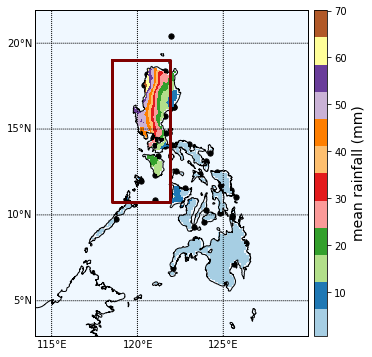

In [10]:
#get latitudes
rain_latitude = np.ma.getdata(daily_rain['lat'])
#get longitudes
rain_longitude = np.ma.getdata(daily_rain['lon'])

lon, lat = np.meshgrid(rain_longitude,rain_latitude)

masked_rain = maskoceans(lon,lat,total_mean_rain.T,resolution='i')
masked_rain.mask[:41,:52] = True

plt.figure(figsize=(8, 6))

#draw basemap
m = Basemap(projection='cyl',llcrnrlon=114.05,urcrnrlon=129.95,llcrnrlat=2.95,urcrnrlat=21.95,resolution='i')
m.drawcoastlines(linewidth=1)
m.drawmapboundary(fill_color='aliceblue')

composite_rain_imshow = m.imshow(masked_rain,cmap='Paired',zorder=1)
x,y = m(station_lon[2:],station_lat[2:])
m.scatter(x, y, marker='.',color='black',s=110)

#draw latitudes and longitudes
parallels = np.arange(5,21,5)
m.drawparallels(parallels,labels=[True,False,True,False])
meridians = np.arange(115,141,5)
m.drawmeridians(meridians,labels=[True,False,False,True])

# m.plot([119,119,126,126,119],[19,12,12,19,19],color='red',linewidth=3) #weather stations
# m.plot([118.5,118.5,121.9,121.9,118.5],[19,10.75,10.75,19,19],color='blue',linewidth=3) #rh domain

m.plot([118.5,118.5,121.9,121.9,118.5],[19,10.75,10.75,19,19],color='maroon',linewidth=3) 

cb = m.colorbar(composite_rain_imshow,'right',shrink=0.5)
cb.set_label(label="mean rainfall (mm)",fontsize=14)

# plt.savefig('../../../MS Thesis/Thesis Manuscript v4/figures/RnD/Strong Habagat/mean_rain.png', dpi=300,bbox_inches='tight')

plt.show()

### Get latitudes and longitudes of set domain

In [12]:
slp_latitude = np.arange(5,23,1.25)
slp_longitude = np.arange(111.25,129,1.25)

## Read csv file containing SLP of strong Habagat days

In [13]:
strong_habagat_slp = pd.read_csv('strong_habagat_slp.csv',header=None).values

In [14]:
strong_habagat_slp.shape

(225, 132)

## Get random indices for training (90% of total)

In [11]:
training_count = np.round(0.9*strong_habagat_slp.shape[1])
test_count = strong_habagat_slp.shape[1]-training_count

rng = rnd.default_rng(seed=0)
training_index = rng.choice(int(strong_habagat_slp.shape[1]), size=int(training_count), replace=False)

In [12]:
total_points = np.arange(strong_habagat_slp.shape[1])
test_index = np.array([i for i in total_points if i not in training_index])

In [13]:
np.save('../Training/Small Domain/test_index.npy',test_index)
np.save('../Training/Small Domain/training_index.npy',training_index)

In [33]:
test_slp = strong_habagat_slp[:,test_index]
train_slp = strong_habagat_slp[:,training_index]
manus_slp = np.max(test_slp[:,[2]],axis=0)

## Get distribution of dates

In [15]:
training_months = np.array(months)[training_index]
training_years = np.array(years_array)[training_index]

test_months = np.array(months)[test_index]
test_years = np.array(years_array)[test_index]

In [16]:
training_years, train_years_count = np.unique(training_years,return_counts = True)
training_months, train_months_count = np.unique(training_months,return_counts = True)

In [18]:
test_years_count = np.zeros(len(train_years_count))
test_months_count = np.zeros(len(train_months_count))

for i in test_months:
    index = np.where(training_months == i)[0][0]
    test_months_count[index] += 1
    
for j in test_years:
    index = np.where(training_years == j)[0][0]
    test_years_count[index] += 1

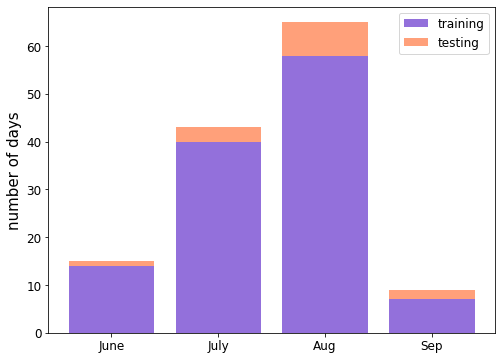

In [32]:
months = ['June','July','Aug','Sep']
plt.figure(figsize=(8,6))
plt.xticks(size=12)
plt.yticks(size=12)
plt.ylabel("number of days",fontsize=15)
plt.bar(months,train_months_count,color='mediumpurple',label='training')
plt.bar(months,test_months_count,color='lightsalmon',bottom=train_months_count,label='testing')
plt.legend(loc='best',fontsize=12)
# plt.savefig('../../../MS Thesis/Thesis Manuscript v4/figures/RnD/habagat_months.png',dpi=300,bbox_inches='tight')
plt.show()

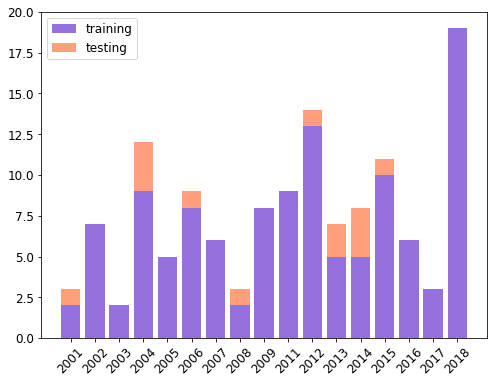

In [33]:
plt.figure(figsize=(8,6))
plt.xticks(size=12,rotation=45)
plt.yticks(size=12)
plt.ylim(top=20)
plt.bar(training_years,train_years_count,color='mediumpurple',label='training')
plt.bar(training_years,test_years_count,color='lightsalmon',bottom=train_years_count,label='testing')
plt.legend(loc='best',fontsize=12)
# plt.savefig('../../For Thesis Manuscript/habagat_years.png',dpi=300,bbox_inches='tight')
plt.show()

### Get randomized training and test SLP

In [17]:
training_SLP = strong_habagat_slp[:,training_index]/strong_habagat_slp[:,training_index].max(axis=0)
test_SLP = strong_habagat_slp[:,test_index]/strong_habagat_slp[:,test_index].max(axis=0)

### Save randomized training and test set to CSV

In [18]:
np.savetxt('../Training/Small Domain/training_SLP.csv',training_SLP,delimiter=',')
np.savetxt('../Training/Small Domain/test_SLP.csv',test_SLP,delimiter=',')

## Read archetypes and weights

In [19]:
MVSA_daily_slp = pd.read_csv('../Training/Small Domain/slp_training_MVSA.csv',header=None)
daily_slp_weights = pd.read_csv('../Training/Small Domain/slp_training_weights.csv',header=None).values

## Find days with threshold SLP weights

In [52]:
slp_archetypes, slp_days = np.where(daily_slp_weights>0.45)

In [53]:
train_slp = np.reshape(train_slp,(len(slp_latitude),len(slp_longitude),119))

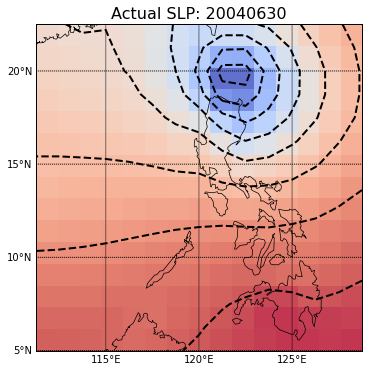

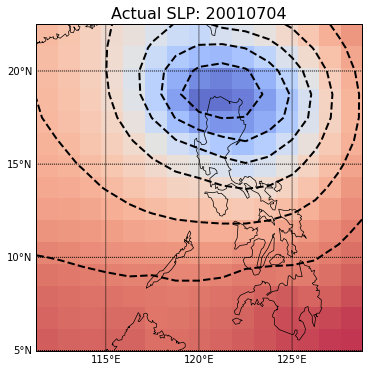

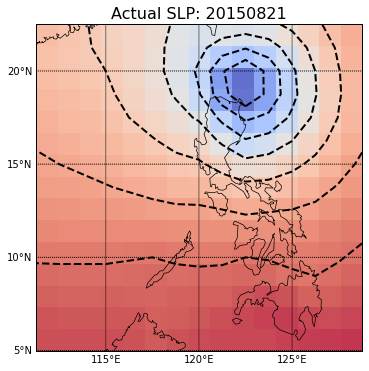

In [79]:
for j in [13, 69, 94]:#[2]: 
    #get normalized actual SLP
    actual_slp = np.flip(train_slp[:,:,j],axis=0)

    fig = plt.figure(figsize=(8, 6))

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=111.25,urcrnrlon=128.75,llcrnrlat=5,urcrnrlat=22.5,resolution='l')
    m.drawcoastlines(linewidth=0.7)
    m.drawmapboundary()
    
    #create isobars
    X, Y = np.meshgrid(slp_longitude, slp_latitude)
    contours = plt.contour(X, Y, actual_slp,colors='black',linestyles='dashed',linewidths=2)

    composite_slp_imshow = m.imshow(actual_slp,cmap='coolwarm',alpha=0.8,zorder=1) #,vmin=0,vmax=1
    plt.title('Actual SLP: '+training_days[training_index][j],fontsize=16)

    #draw latitudes and longitudes
    parallels = np.arange(5,36,5)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(100,141,5)
    m.drawmeridians(meridians,labels=[True,False,False,True])
    
#     plt.savefig('../../../MS Thesis/Thesis Manuscript v4/figures/RnD/Strong Habagat/actualslp_'+str(training_days[training_index][j])+'.png'\
#                 ,dpi=300,bbox_inches='tight')
    plt.show()

In [26]:
training_days = np.load('../training_days.npy')
slp_arch_index = training_index[slp_days]
slp_archetype_dates = np.array(training_days)[np.unique(slp_arch_index)]

In [27]:
np.savetxt('../Training/Small Domain/slp_match_days.txt',np.array(slp_archetype_dates).astype(int))

In [25]:
#get years with archetype dates
years = []
for date in slp_archetype_dates:
    years.append(date[:4])

In [92]:
np.where(slp_archetypes==3)

(array([26, 27, 28], dtype=int64),)

## Filter RH of days that match SLP patterns

In [81]:
strong_habagat_rh = pd.read_csv('strong_habagat_rh.csv',header=None).values

normal_rh = strong_habagat_rh/strong_habagat_rh.max(axis=1)[:,None]

#get training values
training_rh = normal_rh[:,training_index]
#get test values
test_rh = normal_rh[:,test_index]

#get RH of days with matching SLP
matched_rh = training_rh[:,np.unique(slp_days)].T

In [82]:
#save matching RH to csv
np.savetxt('../Training/Small Domain/training_RH.csv',matched_rh,delimiter=',')

#save test RH to csv
np.savetxt('../Training/Small Domain/test_RH.csv',test_rh.T,delimiter=',')

## Get days with analogous RH using threshold

In [109]:
#read csv files of archetypes and weights
MVSA_daily_rh = pd.read_csv('../Training/Small Domain/rh_training_MVSA.csv',header=None)
daily_rh_weights = pd.read_csv('../Training/Small Domain/rh_training_weights.csv',header=None).values

#get RHs with dominant archetypes
rh_archetypes, rh_days = np.where(daily_rh_weights>0.35)
rh_archetype_dates = np.array(slp_archetype_dates)[rh_days]

#get years with archetype dates
years = []
for date in rh_archetype_dates:
    years.append(date[:4])

In [114]:
rh_days

array([32, 21,  3, 16, 22, 39, 40, 41, 42,  4, 12, 19, 28, 30, 34, 43, 31,
       36, 41,  1, 24, 27,  7,  5, 23,  2,  9, 17, 20, 36, 37, 39, 45, 10,
       29, 33], dtype=int64)

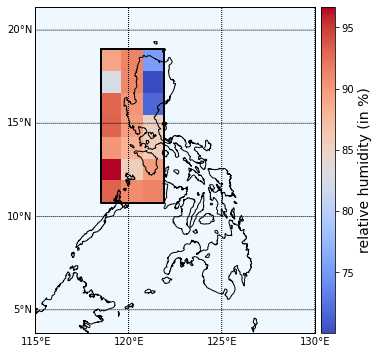

In [112]:
rh_lat = np.arange(3.75,21.5,1.25)
rh_lon = np.arange(115,131,1.25)

for p in [32]:
    rh_matrix = np.zeros((15,13))
    rh_arch = np.reshape(matched_rh[p,:],(3,7))
    
    rh_matrix[6:13,3:6] = 100*rh_arch.T
    
    masked_rh = np.ma.masked_where(rh_matrix==0,rh_matrix)

    plt.figure(figsize=(8,6))

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=115,urcrnrlon=130,llcrnrlat=3.75,urcrnrlat=21.25,resolution='i')
    m.drawcoastlines(linewidth=1)
    m.drawmapboundary(fill_color='aliceblue')

    rh_imshow = m.imshow(masked_rh,cmap='coolwarm',zorder=1)

    #draw latitudes and longitudes
    parallels = np.arange(5,21,5)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(115,141,5)
    m.drawmeridians(meridians,labels=[True,False,False,True])

    m.plot([118.5,118.5,121.9,121.9,118.5],[19,10.75,10.75,19,19],color='black',linewidth=2) 

#     m.colorbar(rh_imshow,'right',shrink=0.5)
    
    cb = m.colorbar(rh_imshow,'right',shrink=0.5)
    cb.set_label(label="relative humidity (in %)",fontsize=14)

    plt.savefig('../../../MS Thesis/Thesis Manuscript v4/figures/RnD/Strong Habagat/rh_'+\
                slp_archetype_dates[p]+'.png', dpi=300,bbox_inches='tight')

    plt.show()

In [116]:
total_mean_rain = np.zeros((191,160,daily_rh_weights.shape[0]))

for j in range(daily_rh_weights.shape[0]):
    index = np.where(rh_archetypes == j)[0]

    year = np.array(years)[index]
    dates = rh_archetype_dates[index]
    days_index = rh_days[index]

    total_rain_matrix = np.zeros((len(dates),160,191))

    for k in range(len(dates)):
        try:
            daily_rain = nc.Dataset('../../Daily Rain/gpm'+year[k]+'/3B-DAY.MS.MRG.3IMERG.'\
                                +dates[k]+'-S000000-E235959.V06.nc4.nc4')
        except FileNotFoundError:
            continue

        rain_data = np.ma.getdata(daily_rain['precipitationCal'][0,:,:])

        total_rain_matrix[k] = rain_data

    #get median total rain
    mean_rain = np.median(total_rain_matrix,axis=0)

    total_mean_rain[:,:,j] = mean_rain.T

# np.save('../Training/Small Domain/rh_training_rain.npy',total_mean_rain)

In [119]:
actual_rain_map.shape

(191, 160, 46)

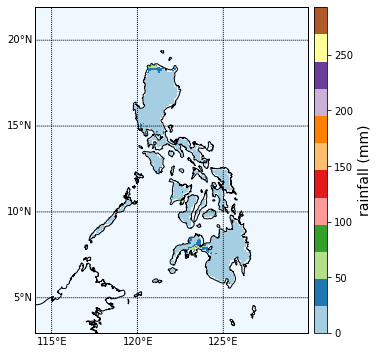

In [121]:
#get latitudes
rain_latitude = np.ma.getdata(daily_rain['lat'])
#get longitudes
rain_longitude = np.ma.getdata(daily_rain['lon'])

lon, lat = np.meshgrid(rain_longitude,rain_latitude)

for j in [32]:#range(composite_rain_map.shape[2]):
    #get masked actual rain
    actual_rain = actual_rain_map[:,:,j] 
    masked_actual = maskoceans(lon,lat,actual_rain,resolution='i')
    masked_actual.mask[:41,:52] = True

    fig = plt.figure(figsize=(8, 6))

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=114.05,urcrnrlon=129.95,llcrnrlat=2.95,urcrnrlat=21.95,resolution='i')
    m.drawcoastlines(linewidth=1)
    m.drawmapboundary(fill_color='aliceblue')

    actual_rain_imshow = m.imshow(masked_actual,cmap='Paired',zorder=1) 
#     plt.title('Actual Rainfall: '+test_days[j],fontsize=16)

    #draw latitudes and longitudes
    parallels = np.arange(5,21,5)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(115,141,5)
    m.drawmeridians(meridians,labels=[True,False,False,True])
    
    cb = m.colorbar(actual_rain_imshow,'right',shrink=0.5)
    cb.set_label(label="rainfall (mm)",fontsize=14)
        
    plt.savefig('../../../MS Thesis/Thesis Manuscript v4/figures/RnD/Strong Habagat/actualrain_'+str(slp_archetype_dates[j])\
                +'.png', dpi=300,bbox_inches='tight')
    
    plt.show()

## Calculate scaling between actual and composite

In [118]:
#get latitudes
rain_latitude = np.ma.getdata(daily_rain['lat'])
#get longitudes
rain_longitude = np.ma.getdata(daily_rain['lon'])

lon, lat = np.meshgrid(rain_longitude,rain_latitude)

composite_rain_map = np.zeros((total_mean_rain.shape[0],total_mean_rain.shape[1],daily_rh_weights.shape[1]))
actual_rain_map = np.copy(composite_rain_map)

for a in range(daily_rh_weights.shape[1]):
    composite_rain_map[:,:,a] = np.sum(daily_rh_weights[:,a]*total_mean_rain,axis=2)
    
    date = slp_archetype_dates[a]
    year = date[:4]
    
    try:
        daily_rain = nc.Dataset('../../Daily Rain/gpm'+year+'/3B-DAY.MS.MRG.3IMERG.'\
                            +date+'-S000000-E235959.V06.nc4.nc4')
    except FileNotFoundError:
        continue
    
    actual_rain_map[:,:,a] = (np.ma.getdata(daily_rain['precipitationCal'][0,:,:])).T

In [31]:
scale = np.mean(actual_rain_map[91:142,60:80],axis=(0,1))/np.mean(composite_rain_map[91:142,60:80],axis=(0,1))
scale = scale[scale!=0]

In [32]:
np.mean(scale)

1.336178630869092

## Get data on observed rainfall from PAGASA stations

In [16]:
station_id = pd.read_csv('../sta_id.csv',header=None)
station_lon = station_id[1].values
station_lat = station_id[2].values

In [17]:
#consider only weather stations in Luzon
#find stations at >10.75 degrees N
lat_ind = station_lat > 10.75 #12.5
station_lat = station_lat[lat_ind]
station_lon = station_lon[lat_ind]

#find stations at <121.9 degrees E
lon_ind = station_lon < 121.9 #124.5 
station_lon = station_lon[lon_ind]
station_lat = station_lat[lon_ind]

In [19]:
station_lon

array([121.85     , 121.4666667, 120.3833333, 120.5333333, 121.6333333,
       121.7333333, 120.3333333, 120.5666667, 120.9666667, 120.9666667,
       121.6333333, 120.9833333, 120.2666667, 121.5833333, 120.9166667,
       121.       , 121.0166667, 121.1833333, 121.05     , 121.35     ,
       121.65     , 120.2      , 121.0333333, 121.0333333])

In [35]:
#get station information of east PH stations
luzon_df = station_id[(station_id[1].isin(station_lon)) & (station_id[2].isin(station_lat))]

#get indices of east PH stations
luzon_ind = luzon_df.index

In [36]:
daily_rain = nc.Dataset('../../Daily Rain/gpm2015/3B-DAY.MS.MRG.3IMERG.20150101-S000000-E235959.V06.nc4.nc4')

#get rainfall latitudes
rain_latitude = np.ma.getdata(daily_rain['lat'])

#get rainfall longitudes
rain_longitude = np.ma.getdata(daily_rain['lon'])

### Find (nearest) index of stations in rainfall grid

In [37]:
lon_ind = []
lat_ind = []

#find nearest corresponding index of stations in rain grid
for i in range(len(station_lon)):
    lon_index = np.abs(rain_longitude-station_lon[i]).argmin()
    lat_index = np.abs(rain_latitude-station_lat[i]).argmin()
    
    lon_ind.append(lon_index)
    lat_ind.append(lat_index)    

In [38]:
#save longitude indices in array
np.save('station_lon_index.npy',lon_ind)

#save latitude indices in array
np.save('station_lat_index.npy',lat_ind)

#save Luzon indices in arrray
np.save('luzon_index.npy',luzon_ind)

### Load observed rainfall per station 

In [39]:
luzon_ind = np.load('luzon_index.npy')
obs_rain = pd.read_csv('../obs_strong_habagat.csv',header=None).values[:,luzon_ind]

test_obs_rain = obs_rain[test_index]
train_obs_rain = obs_rain[np.unique(slp_days)]

### Load indices of longitude and latitude of PAGASA stations in rain grid

In [40]:
station_lon = np.load('station_lon_index.npy')
station_lat = np.load('station_lat_index.npy')

## Compare forecast and actual rainfall, and calculate contingency table

In [41]:
#heavy rain threshold
threshold_rain = [0.5,30]

#neighbour size of forecast
N = [1,2]

#create array containing contingency table per day for different threshold and neighbour size
cont_table = np.zeros((train_obs_rain.shape[0],5,len(threshold_rain),len(N)))

for t in range(len(threshold_rain)):
    for n in range(len(N)):
        for a in range(train_obs_rain.shape[0]):
            #get composite rain
            composite_rain = 1.336178630869092*composite_rain_map[:,:,a] 
            
            for b in range(train_obs_rain.shape[1]):
                lat_index = station_lat[b]
                lon_index = station_lon[b]

                #get actual station rain
                actual_station_rain = train_obs_rain[a][b]

                #check if observed rain is missing
                if np.isnan(actual_station_rain):
                    cont_table[a,4,t] += 1

                else:
                    #get composite station rain within grid
                    composite_station_rain = composite_rain[lat_index-N[n]:lat_index+(N[n]+1), \
                                                            lon_index-N[n]:lon_index+(N[n]+1)]

                    #compare actual rain to grid of forecast
                    diff = np.abs(actual_station_rain-composite_station_rain).argmin()
                    forecast_station_rain = composite_station_rain.flatten()[diff]

                    #count hits per day
                    if actual_station_rain >= threshold_rain[t] and forecast_station_rain >= threshold_rain[t]:
                        cont_table[a,0,t,n] += 1

                    #count false alarms per day
                    elif actual_station_rain < threshold_rain[t] and forecast_station_rain >= threshold_rain[t]:
                        cont_table[a,1,t,n] += 1

                    #count misses per day
                    elif actual_station_rain >= threshold_rain[t] and forecast_station_rain < threshold_rain[t]:
                        cont_table[a,2,t,n] += 1

                    #count correct negatives per day
                    else:
                        cont_table[a,3,t,n] += 1

## Calculate contingency scores

In [42]:
# 0 = hits
# 1 = false alarms
# 2 = misses
# 3 = correct negatives

#calculate threat score
ts = cont_table[:,0,:,:]/(cont_table[:,0,:,:]+cont_table[:,1,:,:]+cont_table[:,2,:,:])

#calculate bias
bias = (cont_table[:,0,:,:]+cont_table[:,1,:,:])/(cont_table[:,0,:,:]+cont_table[:,2,:,:])

#calculate probability of detection
pod = cont_table[:,0,:,:]/(cont_table[:,0,:,:]+cont_table[:,2,:,:])

#calculate false alarm ratio
far = cont_table[:,1,:,:]/(cont_table[:,0,:,:]+cont_table[:,1,:,:])

<ipython-input-42-380e9cbdd595>:10: RuntimeWarning: divide by zero encountered in true_divide
  bias = (cont_table[:,0,:,:]+cont_table[:,1,:,:])/(cont_table[:,0,:,:]+cont_table[:,2,:,:])
<ipython-input-42-380e9cbdd595>:13: RuntimeWarning: invalid value encountered in true_divide
  pod = cont_table[:,0,:,:]/(cont_table[:,0,:,:]+cont_table[:,2,:,:])
<ipython-input-42-380e9cbdd595>:16: RuntimeWarning: invalid value encountered in true_divide
  far = cont_table[:,1,:,:]/(cont_table[:,0,:,:]+cont_table[:,1,:,:])


In [68]:
score_df1 = pd.DataFrame(columns=["date","TS","BIAS","POD","FAR"])
score_df2 = pd.DataFrame(columns=["date","TS","BIAS","POD","FAR"])

In [69]:
ts_ind = np.argsort(ts[:,1,1])

score_df1["TS"] = ts[:,0,1][ts_ind][::-1]
score_df1["BIAS"] = bias[:,0,1][ts_ind][::-1]
score_df1["POD"] = pod[:,0,1][ts_ind][::-1]
score_df1["FAR"] = far[:,0,1][ts_ind][::-1]

score_df1["date"]  = slp_archetype_dates[ts_ind][::-1]

In [70]:
score_df2["TS"] = ts[:,1,1][ts_ind][::-1]
score_df2["BIAS"] = bias[:,1,1][ts_ind][::-1]
score_df2["POD"] = pod[:,1,1][ts_ind][::-1]
score_df2["FAR"] = far[:,1,1][ts_ind][::-1]

score_df2["date"]  = slp_archetype_dates[ts_ind][::-1]

In [71]:
score_df1.to_csv("training_scores05.csv")
score_df2.to_csv("training_scores30.csv")

## Rainfall forecast plots for manuscript

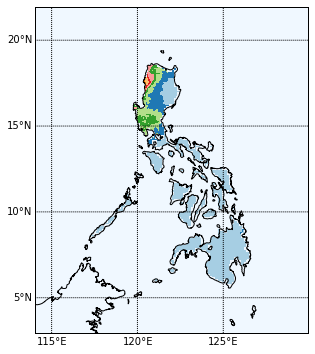

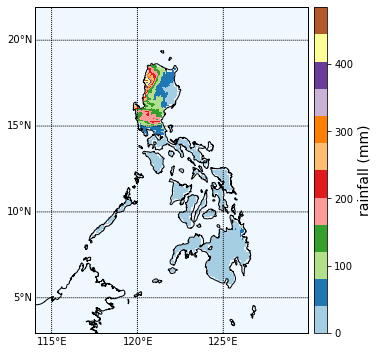

In [60]:
#get latitudes
rain_latitude = np.ma.getdata(daily_rain['lat'])
#get longitudes
rain_longitude = np.ma.getdata(daily_rain['lon'])

lon, lat = np.meshgrid(rain_longitude,rain_latitude)

for j in [5]:#range(composite_rain_map.shape[2]):
    #get masked actual rain
    actual_rain = actual_rain_map[:,:,j] 
    masked_actual = maskoceans(lon,lat,actual_rain,resolution='i')
    masked_actual.mask[:41,:52] = True

    #get masked composite rain
    composite_rain = 1.336178630869092*composite_rain_map[:,:,j] 
    masked_composite = maskoceans(lon,lat,composite_rain,resolution='i')
    masked_composite.mask[:41,:52] = True

    fig = plt.figure(figsize=(8, 6))

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=114.05,urcrnrlon=129.95,llcrnrlat=2.95,urcrnrlat=21.95,resolution='i')
    m.drawcoastlines(linewidth=1)
    m.drawmapboundary(fill_color='aliceblue')

    composite_rain_imshow = m.imshow(masked_composite,cmap='Paired',zorder=1,\
                                     vmin=np.min(masked_actual),vmax=np.max(masked_actual))
#     plt.title('Rainfall Forecast: '+slp_archetype_dates[j],fontsize=16)

    #draw latitudes and longitudes
    parallels = np.arange(5,21,5)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(115,141,5)
    m.drawmeridians(meridians,labels=[True,False,False,True])

#     m.colorbar(composite_rain_imshow,'right',shrink=0.5)
    
#     #display contingency scores at 50mm threshold, N=1
#     plt.text(133,22,'HRT = '+str(threshold_rain[0])+' mm, N = '+str(N[0]*2 + 1),fontsize=11)
#     plt.text(134.5,21,'TS = '+str(np.round(ts[j,0,0],3)),fontsize=10)
#     plt.text(134.5,20,'BIAS = '+str(np.round(bias[j,0,0],3)),fontsize=10)
#     plt.text(134.5,19,'POD = '+str(np.round(pod[j,0,0],3)),fontsize=10)
#     plt.text(134.5,18,'FAR = '+str(np.round(far[j,0,0],3)),fontsize=10)

#     #display contingency scores at 75mm threshold, N=1
#     plt.text(133,17,'HRT = '+str(threshold_rain[1])+' mm, N = '+str(N[0]*2 + 1),fontsize=11)
#     plt.text(134.5,16,'TS = '+str(np.round(ts[j,1,0],3)),fontsize=10)
#     plt.text(134.5,15,'BIAS = '+str(np.round(bias[j,1,0],3)),fontsize=10)
#     plt.text(134.5,14,'POD = '+str(np.round(pod[j,1,0],3)),fontsize=10)
#     plt.text(134.5,13,'FAR = '+str(np.round(far[j,1,0],3)),fontsize=10)

#     #display contingency scores at 50mm threshold, N=2
#     plt.text(133,12,'HRT = '+str(threshold_rain[0])+' mm, N = '+str(N[1]*2 + 1),fontsize=11)
#     plt.text(134.5,11,'TS = '+str(np.round(ts[j,1,1],3)),fontsize=10)
#     plt.text(134.5,10,'BIAS = '+str(np.round(bias[j,1,1],3)),fontsize=10)
#     plt.text(134.5,9,'POD = '+str(np.round(pod[j,1,1],3)),fontsize=10)
#     plt.text(134.5,8,'FAR = '+str(np.round(far[j,1,1],3)),fontsize=10)

#     #display contingency scores at 75mm threshold, N=2
#     plt.text(133,7,'HRT = '+str(threshold_rain[1])+' mm, N = '+str(N[1]*2 + 1),fontsize=11)
#     plt.text(134.5,6,'TS = '+str(np.round(ts[j,1,1],3)),fontsize=10)
#     plt.text(134.5,5,'BIAS = '+str(np.round(bias[j,1,1],3)),fontsize=10)
#     plt.text(134.5,4,'POD = '+str(np.round(pod[j,1,1],3)),fontsize=10)
#     plt.text(134.5,3,'FAR = '+str(np.round(far[j,1,1],3)),fontsize=10)

#     plt.savefig('../../../MS Thesis/Thesis Manuscript v4/figures/RnD/Strong Habagat/small_rain_'+str(slp_archetype_dates[j])\
#                 +'.png',dpi=300,bbox_inches='tight')
    plt.show()

    fig = plt.figure(figsize=(8, 6))

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=114.05,urcrnrlon=129.95,llcrnrlat=2.95,urcrnrlat=21.95,resolution='i')
    m.drawcoastlines(linewidth=1)
    m.drawmapboundary(fill_color='aliceblue')

    actual_rain_imshow = m.imshow(masked_actual,cmap='Paired',zorder=1) 
#     plt.title('Actual Rainfall: '+test_days[j],fontsize=16)

    #draw latitudes and longitudes
    parallels = np.arange(5,21,5)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(115,141,5)
    m.drawmeridians(meridians,labels=[True,False,False,True])
    
    cb = m.colorbar(actual_rain_imshow,'right',shrink=0.5)
    cb.set_label(label="rainfall (mm)",fontsize=14)
        
#     plt.savefig('../../../MS Thesis/Thesis Manuscript v4/figures/RnD/Strong Habagat/actualrain_'+str(slp_archetype_dates[j])\
#                 +'.png', dpi=300,bbox_inches='tight')
    
    plt.show()